In [3]:
# Gerekli kütüphanelerin yüklenmesi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings

# ML kütüphaneleri
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.svm import SVR

# Etkileşimli görselleştirmeler için
import plotly.io as pio
pio.templates.default = "plotly_white"

# Uyarıları bastır
warnings.filterwarnings('ignore')

# Stil ayarı
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

In [2]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [4]:
# Veri setini yükle
df = pd.read_csv('/content/salaries.csv')

#Genel bakış
print(f"Dataset Shape: {df.shape}")
print(f"\nMemory Usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print("\nFirst few rows:")
df.head()

Dataset Shape: (141566, 11)

Memory Usage: 11.88 MB

First few rows:


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2025,EN,FT,Data Quality Analyst,60000,GBP,75949,GB,0,GB,M
1,2025,EN,FT,Data Quality Analyst,48000,GBP,60759,GB,0,GB,M
2,2025,SE,FT,Applied Scientist,266000,USD,266000,US,0,US,M
3,2025,SE,FT,Applied Scientist,204000,USD,204000,US,0,US,M
4,2025,SE,FT,Data Scientist,291000,USD,291000,US,0,US,M


In [5]:
# # Veri kümesi hakkında bilgi görüntüle
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141566 entries, 0 to 141565
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   work_year           141566 non-null  int64 
 1   experience_level    141566 non-null  object
 2   employment_type     141566 non-null  object
 3   job_title           141566 non-null  object
 4   salary              141566 non-null  int64 
 5   salary_currency     141566 non-null  object
 6   salary_in_usd       141566 non-null  int64 
 7   employee_residence  141566 non-null  object
 8   remote_ratio        141566 non-null  int64 
 9   company_location    141566 non-null  object
 10  company_size        141566 non-null  object
dtypes: int64(4), object(7)
memory usage: 11.9+ MB


In [6]:
# Sayısal sütunların istatistiksel özeti
df.describe().T.style.background_gradient(cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
work_year,141566.000000,2024.395907,0.677544,2020.000000,2024.000000,2024.000000,2025.000000,2025.000000
salary,141566.000000,162971.880628,212678.100536,14000.000000,106000.000000,147000.000000,198873.250000,30400000.000000
salary_in_usd,141566.000000,157496.750682,74132.383476,15000.000000,106000.000000,146147.500000,198000.000000,800000.000000
remote_ratio,141566.000000,20.963720,40.634986,0.000000,0.000000,0.000000,0.000000,100.000000


In [7]:
# Eksik değerleri kontrol etme
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percent
})

print("Missing values check:")
missing_df[missing_df['Missing Values'] > 0]

Missing values check:


,Missing Values,Percentage


Eksik değer içermeyen temiz bir veri setimiz var. Keşiflerimize devam edelim.

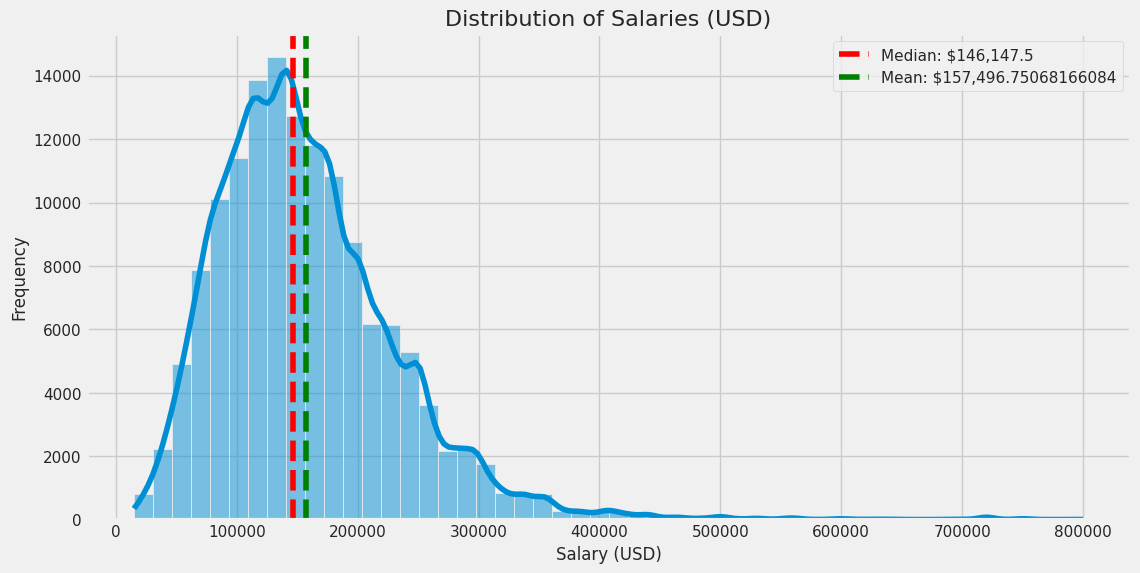

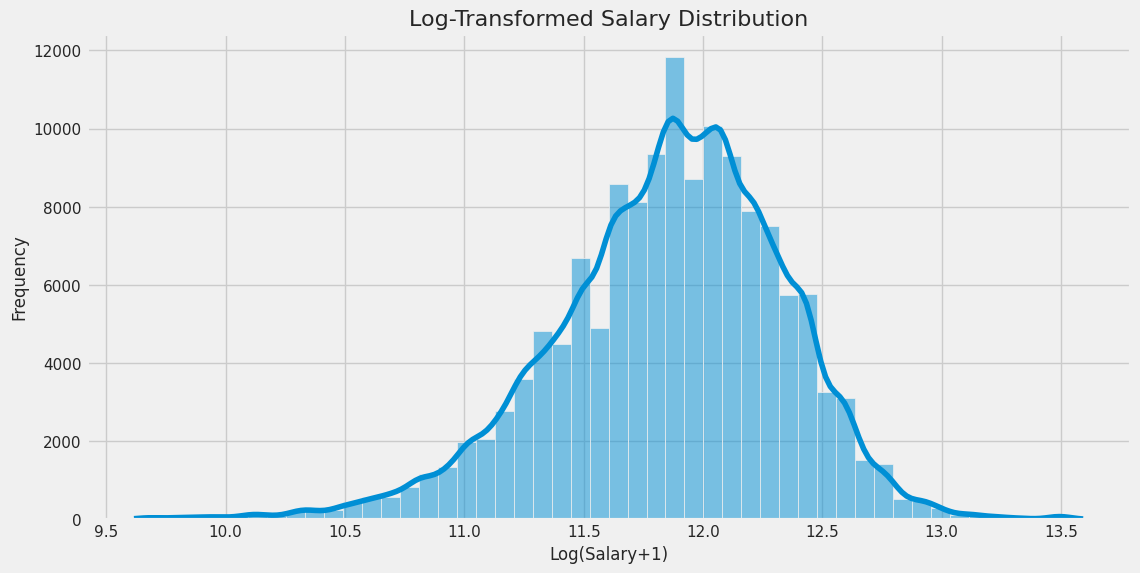

In [8]:
#Keşifsel Veri Analizi

# ABD doları cinsinden maaş dağılımı
plt.figure(figsize=(12, 6))
sns.histplot(df['salary_in_usd'], kde=True, bins=50)
plt.title('Distribution of Salaries (USD)', fontsize=16)
plt.xlabel('Salary (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(df['salary_in_usd'].median(), color='red', linestyle='--', label=f'Median: ${df["salary_in_usd"].median():,}')
plt.axvline(df['salary_in_usd'].mean(), color='green', linestyle='--', label=f'Mean: ${df["salary_in_usd"].mean():,}')
plt.legend()
plt.show()

# Logaritmik olarak dönüştürülmüş maaş dağılımı (çarpıklığı gidermek için)
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['salary_in_usd']), kde=True, bins=50)
plt.title('Log-Transformed Salary Distribution', fontsize=16)
plt.xlabel('Log(Salary+1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [ ]:
#Maaş dağılımı sağa çarpıktır ve önemli sayıda yüksek maaşlı aykırı değer içerir. Bu, maaş verileri için tipik bir durumdur. Logaritmik dönüşüm bize daha normal bir dağılım sağlar ve bu da modelleme için faydalı olacaktır.

In [9]:
#Zaman İçinde Maaş Eğilimleri

yearly_stats = df.groupby('work_year')['salary_in_usd'].agg(['mean', 'median', 'std']).reset_index()

fig = px.line(yearly_stats, x='work_year', y=['mean', 'median'],
              title='Data Science Salary Trends (2020-2025)',
              labels={'value': 'Salary (USD)', 'work_year': 'Year', 'variable': 'Metric'},
              template='plotly_white')

fig.update_layout(legend_title_text='', hovermode='x unified',
                 width=900, height=500)

# Standart sapma için aralık ekleme
fig.add_trace(go.Scatter(
    x=np.concatenate([yearly_stats['work_year'], yearly_stats['work_year'][::-1]]),
    y=np.concatenate([yearly_stats['mean'] + yearly_stats['std'],
                     (yearly_stats['mean'] - yearly_stats['std'])[::-1]]),
    fill='toself',
    fillcolor='rgba(0,100,80,0.2)',
    line=dict(color='rgba(255,255,255,0)'),
    name='Standard Deviation'
))

fig.show()

2020'den 2025'e hem ortalama hem de medyan maaşlarda istikrarlı bir artış gözlemliyoruz, ancak aralarındaki fark biraz açılıyor ve bu da alanda eşitsizliğin arttığını gösteriyor.

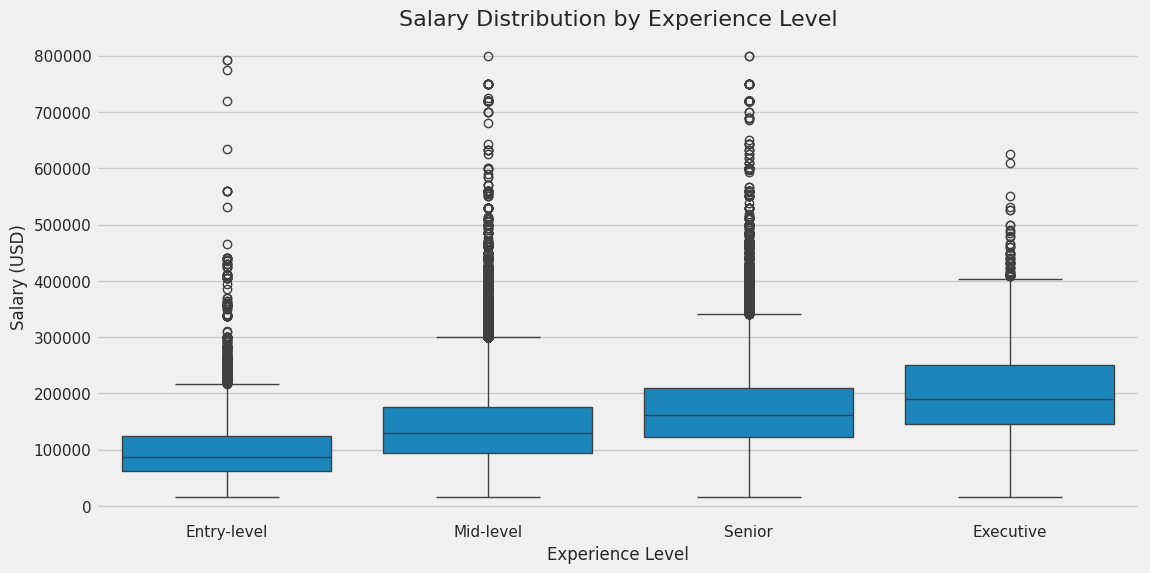

In [10]:
# Deneyim seviyesi maaş karşılaştırması
plt.figure(figsize=(12, 6))
sns.boxplot(x='experience_level', y='salary_in_usd', data=df, order=['EN', 'MI', 'SE', 'EX'])
plt.title('Salary Distribution by Experience Level', fontsize=16)
plt.xlabel('Experience Level', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(ticks=[0, 1, 2, 3], labels=['Entry-level', 'Mid-level', 'Senior', 'Executive'])
plt.show()

# Zaman içinde deneyim düzeyine göre ortalama maaş
exp_time = df.groupby(['work_year', 'experience_level'])['salary_in_usd'].mean().reset_index()
exp_time['experience_level'] = exp_time['experience_level'].replace({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.line(exp_time, x='work_year', y='salary_in_usd', color='experience_level',
             title='Salary Trends by Experience Level (2020-2025)',
             labels={'salary_in_usd': 'Average Salary (USD)', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

Beklendiği gibi, deneyim seviyesinin maaş üzerinde önemli bir etkisi vardır ve yöneticiler diğer seviyelerdeki yöneticilerden önemli ölçüde daha fazla kazanmaktadır. Yönetici maaşlarındaki artış oranı daha dik görünmektedir ve bu da liderlik rolleri için primlerin arttığını göstermektedir.

Distribution of top job titles:
job_title
Data Scientist               17934
Software Engineer            15880
Data Engineer                15539
Data Analyst                 13087
Engineer                     10144
Machine Learning Engineer     8509
Manager                       7189
Analyst                       4792
Research Scientist            3306
Product Manager               2386
Applied Scientist             2283
Associate                     2215
Data Architect                2112
Analytics Engineer            1997
AI Engineer                   1796
Name: count, dtype: int64


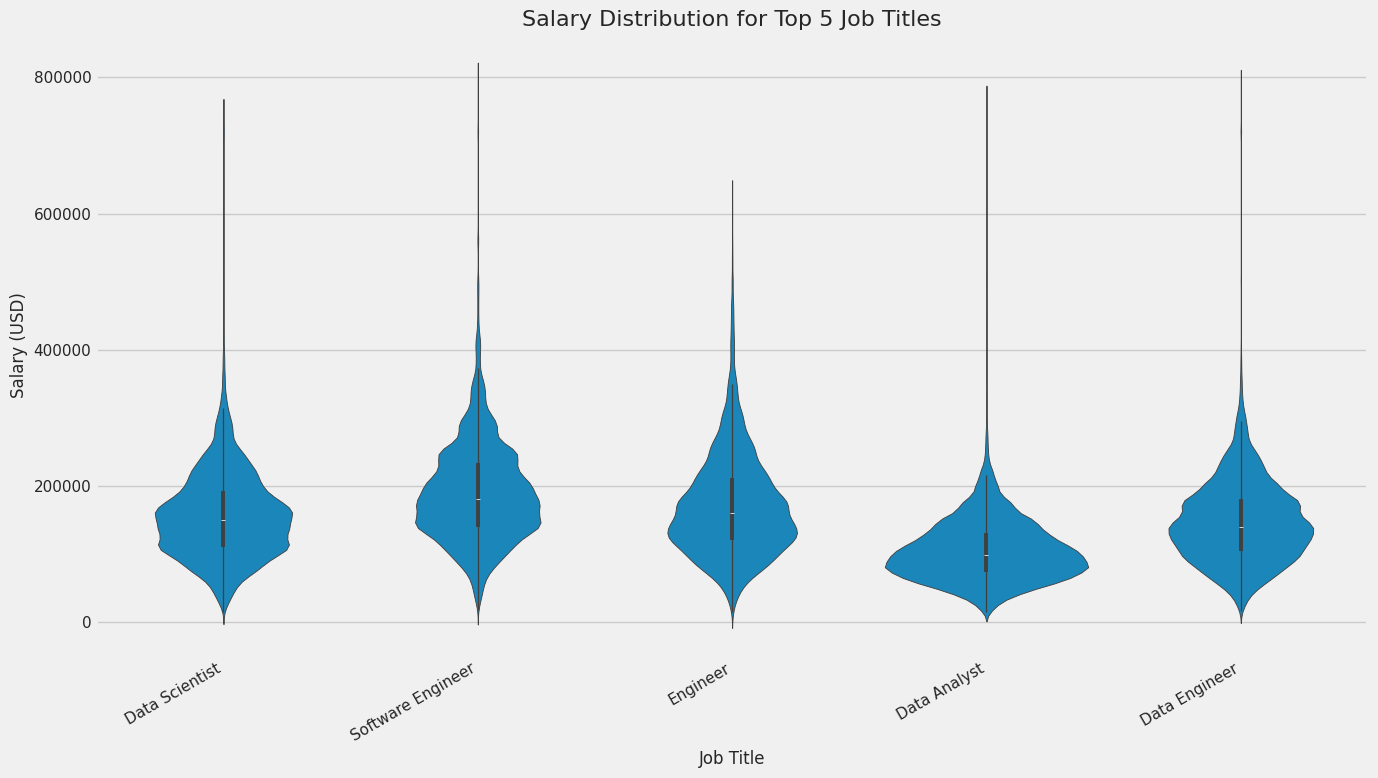

In [12]:
#Meslek Başlıkları Analizi
#Sayıya göre en iyi 15 iş unvanı
top_jobs = df['job_title'].value_counts().head(15)
print("Distribution of top job titles:")
print(top_jobs)

#En iyi iş unvanları için ortalama maaş
top_jobs_salary = df[df['job_title'].isin(top_jobs.index)].groupby('job_title')['salary_in_usd'].mean().sort_values(ascending=False)

fig = px.bar(x=top_jobs_salary.index, y=top_jobs_salary.values,
            labels={'x': 'Job Title', 'y': 'Average Salary (USD)'},
            title='Average Salary by Top Job Titles',
            color=top_jobs_salary.values, color_continuous_scale='Viridis')

fig.update_layout(xaxis_tickangle=-45, width=1000, height=600)
fig.show()

# En iyi 5 iş unvanı için maaş dağılımı
plt.figure(figsize=(14, 8))
top5_jobs = top_jobs.index[:5]
sns.violinplot(x='job_title', y='salary_in_usd', data=df[df['job_title'].isin(top5_jobs)])
plt.title('Salary Distribution for Top 5 Job Titles', fontsize=16)
plt.xlabel('Job Title', fontsize=12)
plt.ylabel('Salary (USD)', fontsize=12)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

En yaygın iş unvanları arasında Makine Öğrenimi Mühendisleri ve Araştırma Bilim İnsanları genellikle en yüksek maaşları alırken, Veri Analistleri genellikle daha az kazanır. Yazılım Mühendisleri, bu unvan altındaki çeşitli rolleri yansıtarak en geniş maaş dağılımına sahiptir.

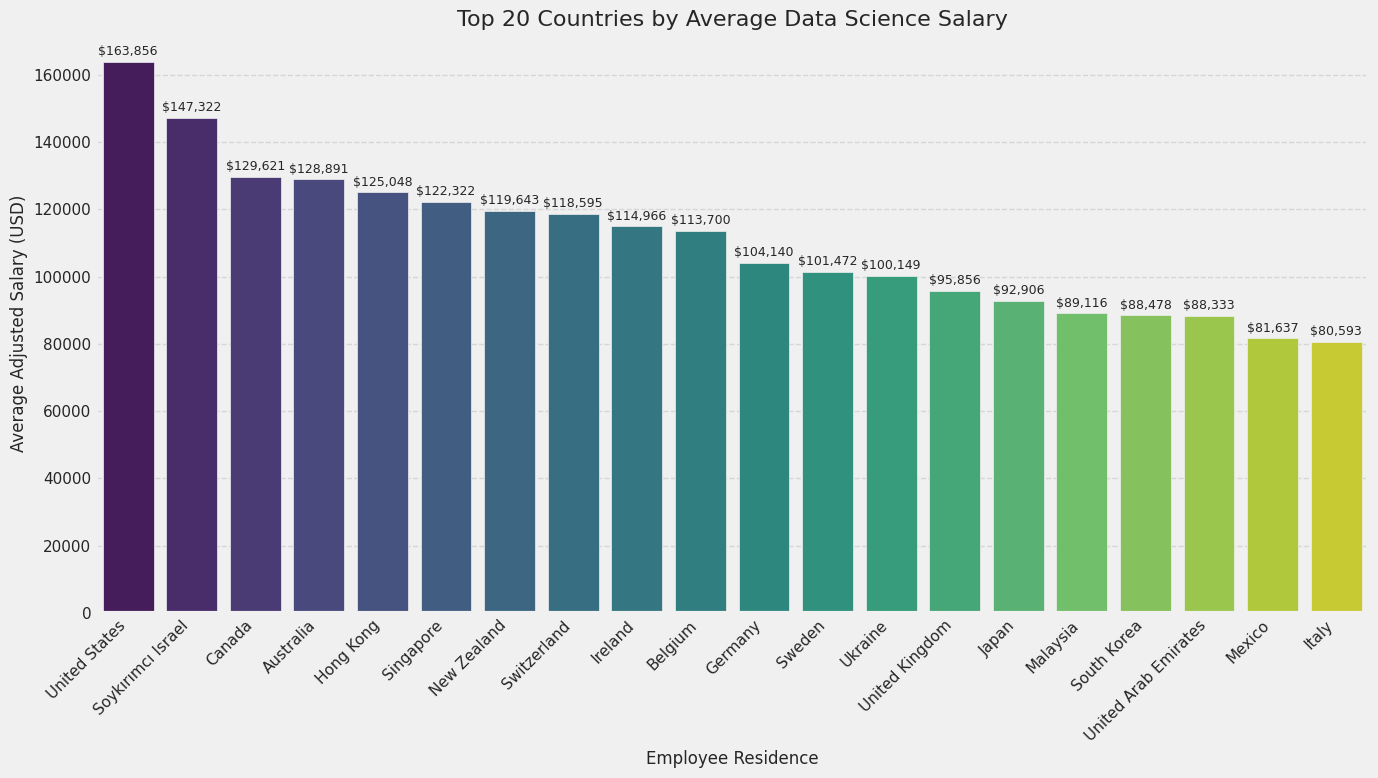

In [15]:
#Coğrafi Analiz¶
# İlk olarak adjusted_salary sütununu oluşturalım (maaş_in_usd'ye dayalı olduğunu varsayarak)
df['adjusted_salary'] = df['salary_in_usd']  # Belirli bir ayarlama formülü varsa bunu değiştirebilirsiniz

# Görselleştirme için ISO-2'den ülke adlarına eşleme oluştrma
iso2_to_name = {
    'US': 'United States', 'GB': 'United Kingdom', 'DE': 'Germany', 'FR': 'France',
    'CA': 'Canada', 'IN': 'India', 'AU': 'Australia', 'ES': 'Spain', 'BR': 'Brazil',
    'NL': 'Netherlands', 'JP': 'Japan', 'CH': 'Switzerland', 'IT': 'Italy',
    'SG': 'Singapore', 'SE': 'Sweden', 'MX': 'Mexico', 'FI': 'Finland', 'DK': 'Denmark',
    'PL': 'Poland', 'PT': 'Portugal', 'NZ': 'New Zealand', 'IE': 'Ireland',
    'HK': 'Hong Kong', 'RU': 'Russia', 'BE': 'Belgium', 'IL': 'Soykırımcı Israel',
    'UA': 'Ukraine', 'TR': 'Turkiye', 'AE': 'United Arab Emirates', 'ZA': 'South Africa',
    'CO': 'Colombia', 'AR': 'Argentina', 'CL': 'Chile', 'AT': 'Austria', 'MY': 'Malaysia',
    'NG': 'Nigeria', 'VN': 'Vietnam', 'KR': 'South Korea', 'TH': 'Thailand'

}

# Çalışanın ikametgahına göre ortalama maaşı hesapla
avg_salary_by_residence = df.groupby('employee_residence')['adjusted_salary'].mean().reset_index()

# Haritalama için ülke adlarını ekle
avg_salary_by_residence['country_name'] = avg_salary_by_residence['employee_residence'].map(iso2_to_name)
avg_salary_by_residence = avg_salary_by_residence.dropna(subset=['country_name'])  # Drop unmapped countries

# Koroplet haritasını oluştur
fig2 = px.choropleth(avg_salary_by_residence,
                     locations='country_name',
                     locationmode='country names',
                     color='adjusted_salary',
                     hover_name='country_name',
                     hover_data={'employee_residence': True, 'adjusted_salary': ':,.0f'},
                      color_continuous_scale=px.colors.sequential.Plasma,
                     title='Average Salary by Employee Residence',
                     labels={'adjusted_salary': 'Average Adjusted Salary'},
                     projection='natural earth')

fig2.update_layout(width=1000, height=600)
fig2.show()

# En iyi 20 ülke için sıralı bir çubuk grafiği oluştur
top_countries = avg_salary_by_residence.sort_values('adjusted_salary', ascending=False).head(20)

plt.figure(figsize=(14, 8))
chart = sns.barplot(x='country_name', y='adjusted_salary', data=top_countries,
                    palette='viridis', order=top_countries['country_name'])
plt.title('Top 20 Countries by Average Data Science Salary', fontsize=16)
plt.xlabel('Employee Residence', fontsize=12)
plt.ylabel('Average Adjusted Salary (USD)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Çubukların üstüne maaş değerlerini ekle
for i, bar in enumerate(chart.patches):
    chart.text(bar.get_x() + bar.get_width()/2.,
              bar.get_height() + 2000,
              f'${top_countries["adjusted_salary"].iloc[i]:,.0f}',
              ha='center', fontsize=9)

plt.tight_layout()
plt.show()


ABD, İsviçre ve İsrail veri bilimi maaşlarında başı çekiyor. İlginç bir şekilde, ikamet ettikleri ülke dışındaki şirketlerde çalışan profesyoneller ortalama olarak daha fazla kazanıyor ve bu da yüksek maaşlı pazarlardaki şirketlerle uzaktan çalışma düzenlemelerinin avantajlarını vurguluyor.

In [16]:
#Remote Çalışma
# Ortalama Remote Maaşları
remote_salary = df.groupby('remote_ratio')['salary_in_usd'].agg(['mean', 'median', 'count']).reset_index()
remote_salary['remote_ratio'] = remote_salary['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.bar(remote_salary, x='remote_ratio', y=['mean', 'median'],
            barmode='group', title='Salary by Remote Work Ratio',
            labels={'value': 'Salary (USD)', 'remote_ratio': 'Work Setting', 'variable': 'Metric'},
            color_discrete_sequence=['#2a9d8f', '#e76f51'])

fig.update_layout(width=800, height=500)
fig.show()

# Zaman içinde remote oran eğilimleri
remote_time = df.groupby(['work_year', 'remote_ratio']).size().reset_index(name='count')
total_per_year = remote_time.groupby('work_year')['count'].sum().reset_index()
remote_time = remote_time.merge(total_per_year, on='work_year', suffixes=('', '_total'))
remote_time['percentage'] = (remote_time['count'] / remote_time['count_total']) * 100
remote_time['remote_ratio'] = remote_time['remote_ratio'].map({0: 'On-site', 50: 'Hybrid', 100: 'Remote'})

fig = px.line(remote_time, x='work_year', y='percentage', color='remote_ratio',
             title='Remote Work Trends (2020-2025)',
             labels={'percentage': 'Percentage of Jobs', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

Tamamen uzaktan çalışma pozisyonları ortalama olarak daha yüksek maaşlar sunma eğilimindedir. 2020'den sonra (muhtemelen COVID-19 pandemisinden dolayı) uzaktan çalışmaya doğru önemli bir kayma da gözlemleyebiliriz. Bu eğilim 2023-2024 civarında istikrar kazansa da, 2020 öncesi seviyelere kıyasla hala daha yüksek bir uzaktan çalışma yüzdesi göstermektedir.

In [17]:
#Şirket Büyüklüğü Etkisi
# Şirket büyüklüğüne göre maaş
company_salary = df.groupby(['company_size', 'experience_level'])['salary_in_usd'].median().reset_index()
company_salary['company_size'] = company_salary['company_size'].map({'S': 'Small', 'M': 'Medium', 'L': 'Large'})
company_salary['experience_level'] = company_salary['experience_level'].map({
    'EN': 'Entry-level', 'MI': 'Mid-level', 'SE': 'Senior', 'EX': 'Executive'
})

fig = px.bar(company_salary, x='company_size', y='salary_in_usd', color='experience_level',
            barmode='group', title='Median Salary by Company Size and Experience Level',
            labels={'salary_in_usd': 'Median Salary (USD)', 'company_size': 'Company Size'},
            template='plotly_white')

fig.update_layout(width=900, height=500)
fig.show()

Daha büyük şirketler genellikle tüm deneyim seviyelerinde daha yüksek maaşlar sunar ve bu fark en çok yönetici seviyesinde belirgindir. Bu durum, daha büyük kuruluşların daha fazla kaynağa ve gelire sahip olduğunu gösterir.

In [18]:
#Döviz Analizi
# en yüksek maaş para birimleri
currency_counts = df['salary_currency'].value_counts().head(10)

fig = px.pie(values=currency_counts.values, names=currency_counts.index,
            title='Distribution of Salary Currencies',
            template='plotly_white')

fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(width=700, height=500)
fig.show()

# Döviz kuru analizi (maaş ve salary_in_usd'den çıkarılmıştır)
df['implied_exchange_rate'] = df['salary'] / df['salary_in_usd']
top_currencies = df['salary_currency'].value_counts().head(10).index.tolist()
exchange_rates = df[df['salary_currency'].isin(top_currencies)].groupby(['work_year', 'salary_currency'])['implied_exchange_rate'].median().reset_index()

fig = px.line(exchange_rates, x='work_year', y='implied_exchange_rate', color='salary_currency',
             title='Implied Exchange Rate Trends (2020-2025)',
             labels={'implied_exchange_rate': 'Rate vs USD', 'work_year': 'Year'},
             template='plotly_white')

fig.update_layout(width=900, height=500, hovermode='x unified')
fig.show()

ABD doları, dünya genelinde veri bilimi maaşları için birincil para birimi olarak hakim konumdadır. Döviz kuru analizi, zaman içinde göreceli döviz gücünü gösterirken, bazı para birimlerinin ABD doları karşısında değer kaybettiğini göstermektedir.

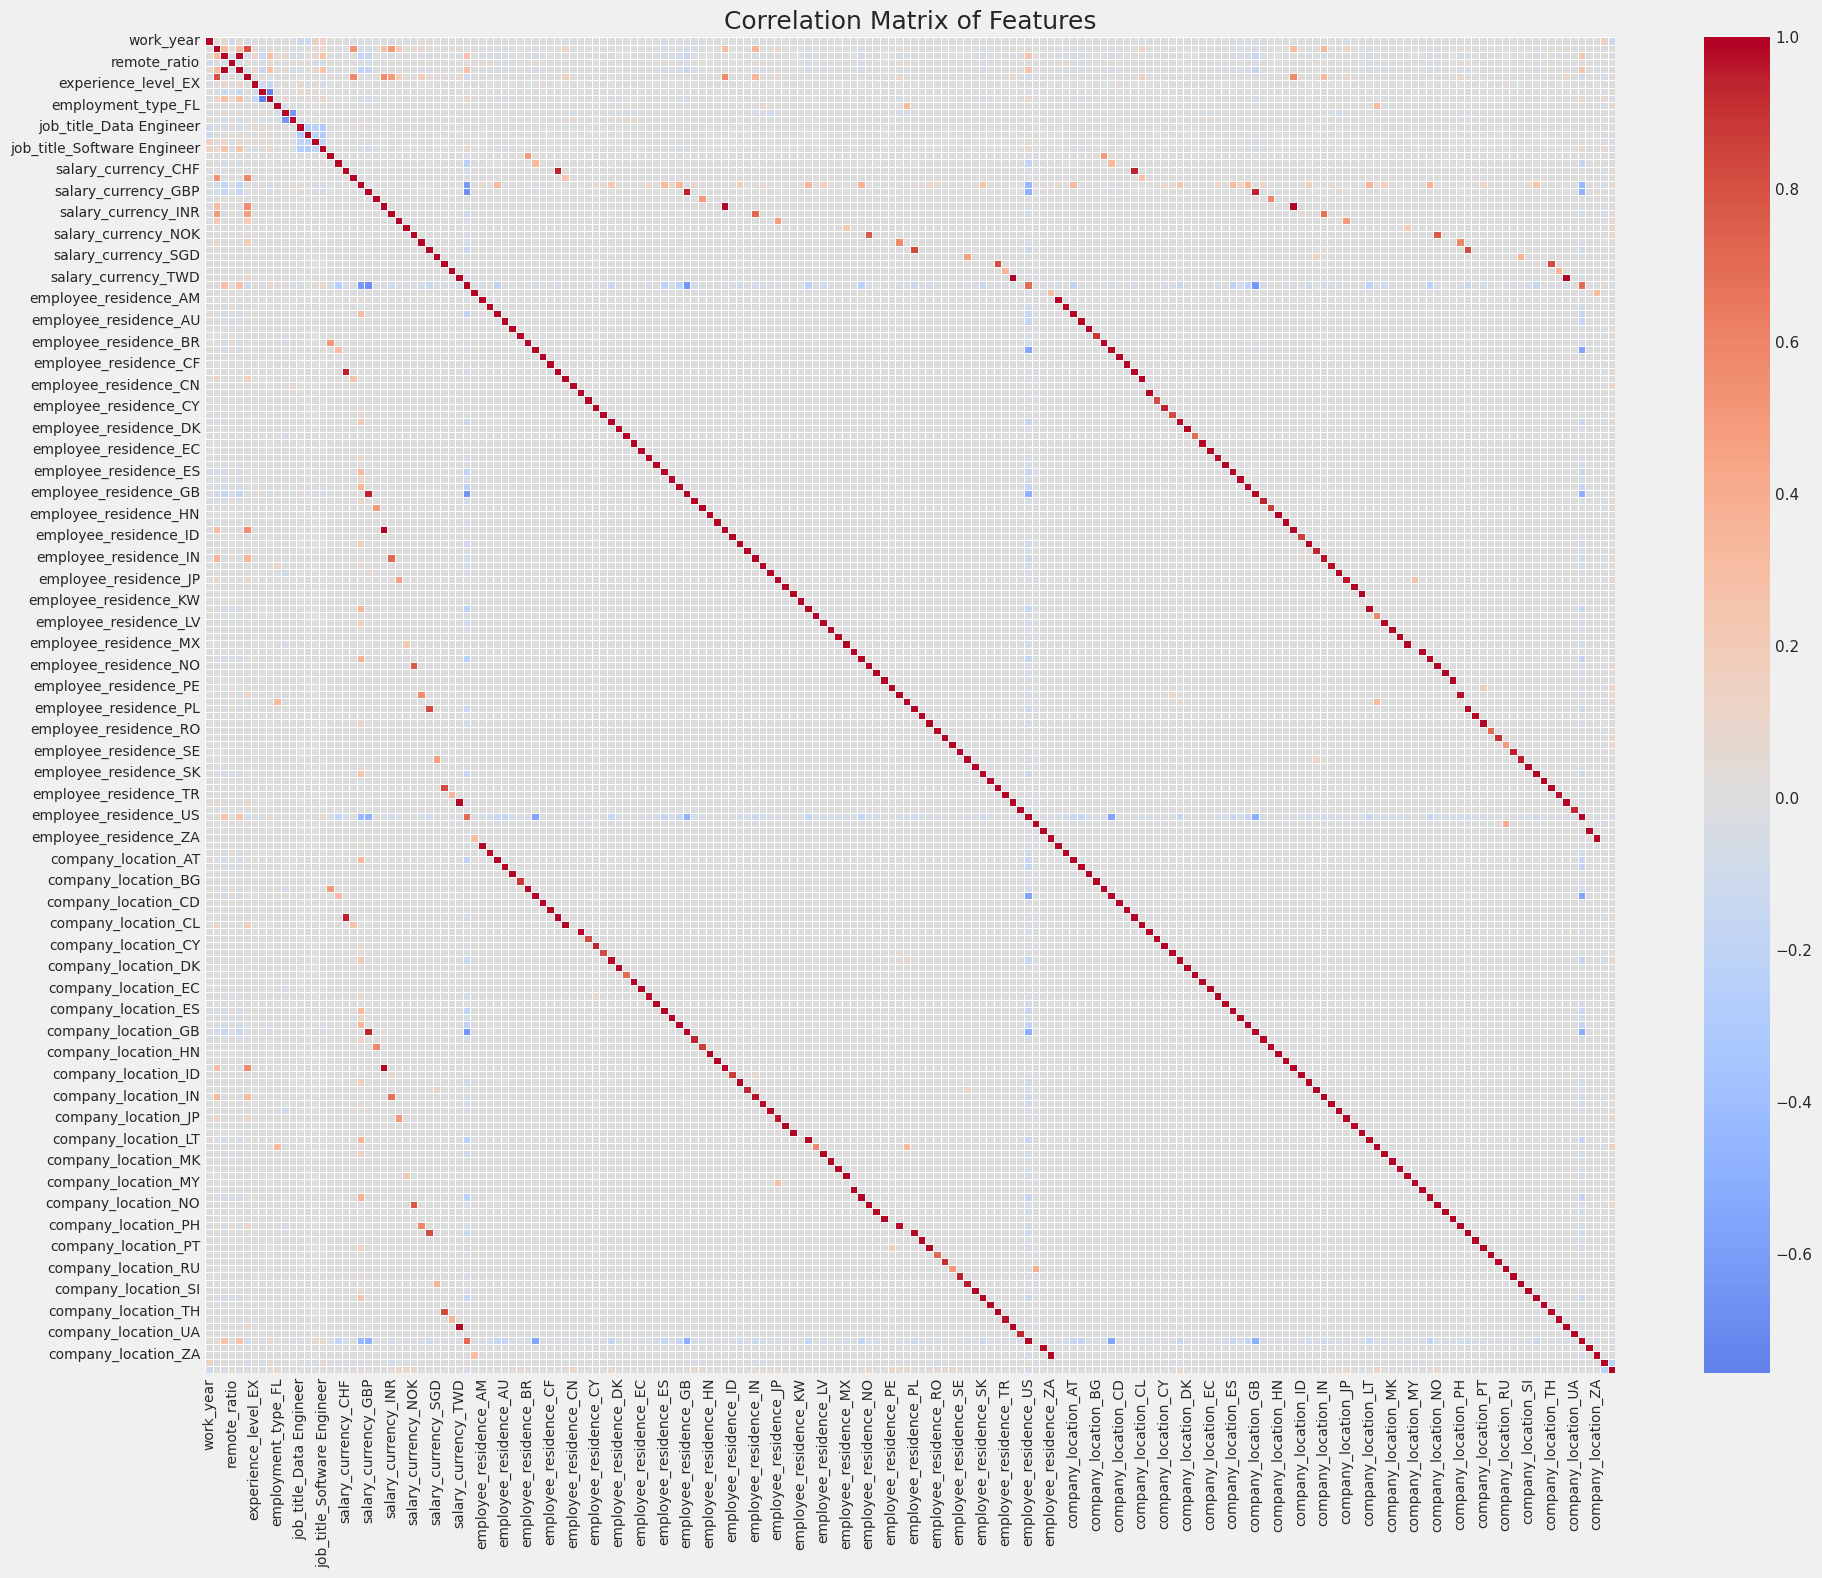

Top 10 features positively correlated with salary:
adjusted_salary                1.000000
salary_in_usd                  1.000000
salary                         0.312158
experience_level_SE            0.283090
salary_currency_USD            0.273329
job_title_Software Engineer    0.263941
employee_residence_US          0.260671
company_location_US            0.259873
experience_level_EX            0.100351
job_title_Engineer             0.091414
employment_type_FT             0.067459
Name: salary_in_usd, dtype: float64

Top 10 features negatively correlated with salary:
company_location_ES     -0.069030
company_location_FR     -0.071843
employee_residence_FR   -0.072456
company_location_LT     -0.076052
employee_residence_LT   -0.076052
experience_level_MI     -0.140083
employee_residence_GB   -0.154147
company_location_GB     -0.154507
salary_currency_GBP     -0.163104
salary_currency_EUR     -0.196424
Name: salary_in_usd, dtype: float64


In [19]:
#Korelasyon Analizi
# Kategorik özellikler için yeni değişkenler oluştur
categorical_cols = ['experience_level', 'employment_type', 'job_title', 'salary_currency',
                    'employee_residence', 'company_location', 'company_size']
numerical_cols = ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']

# Basitleştirilmiş korelasyon analizi için en iyi iş unvanlarını seç
top_job_titles = df['job_title'].value_counts().head(5).index.tolist()
df_corr = df[df['job_title'].isin(top_job_titles)].copy()

# Yapay değişkenler oluştur
df_dummies = pd.get_dummies(df_corr, columns=categorical_cols, drop_first=True)

# Korelasyon matrisini hesapla ve çiz
corr_matrix = df_dummies.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Features', fontsize=18)
plt.xticks(fontsize=10, rotation=90)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Temel maaş korelasyonları
salary_corr = corr_matrix['salary_in_usd'].sort_values(ascending=False)
print("Top 10 features positively correlated with salary:")
print(salary_corr.head(11))  # Including salary_in_usd itself
print("\nTop 10 features negatively correlated with salary:")
print(salary_corr.tail(10))

Korelasyon analizi, maaş ile deneyim seviyesi, şirket büyüklüğü ve belirli iş unvanları gibi faktörler arasında güçlü ilişkiler olduğunu ortaya koymaktadır. Bu bilgileri, modellerimizde özellik seçimi için kullanabiliriz.